In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

from prepare_lyft_data import extract_single_box, \
    parse_train_csv, level5data, extract_boxed_clouds, \
    get_sample_images, get_train_data_sample_token_and_box, \
    get_pc_in_image_fov, get_bounding_box_corners, \
    get_2d_corners_from_projected_box_coordinates, transform_image_to_world_coordinate,\
transform_world_to_image_coordinate,transform_box_from_world_to_sensor_coordinates,\
transform_box_from_world_to_ego_coordinates,transform_box_from_world_to_flat_vehicle_coordinates,\
transform_box_from_world_to_flat_sensor_coordinates
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud,Quaternion

In [55]:
data_idx=13
train_df = parse_train_csv()
sample_token, bounding_box = get_train_data_sample_token_and_box(13, train_df)
first_train_sample = level5data.get('sample', sample_token)

100%|██████████| 22680/22680 [00:02<00:00, 9683.11it/s] 


## The details of the rotating axis

Box in world coordinates

In [56]:
bounding_box

label: nan, score: nan, xyz: [2701.56, 693.72, -18.01], wlh: [2.03, 5.30, 2.23], rot axis: [0.00, 0.00, 1.00], ang(degrees): 148.47, ang(rad): 2.59, vel: nan, nan, nan, name: car, token: None

Rotating angle

In [57]:
bounding_box.orientation.degrees

148.47157839229075

Text(0, 0.5, 'y axis')

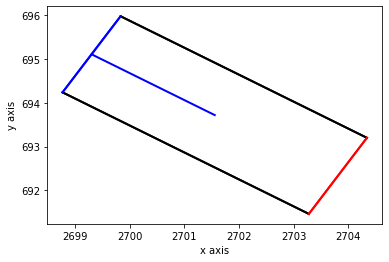

In [58]:
fig,ax=plt.subplots()
view_mtx=np.array([[1,0],[0,1]])
bounding_box.render(ax,view=view_mtx)
plt.xlabel("x axis")
plt.ylabel("y axis")

We could see that the rotation is from x-axis, counterclockwise.

In [59]:
camera_token=first_train_sample['data']['CAM_FRONT']

## Convert to camera coordiante

In [60]:
bounding_box_in_camera_coord=transform_box_from_world_to_sensor_coordinates(bounding_box,camera_token)

Text(0, 0.5, 'z axis')

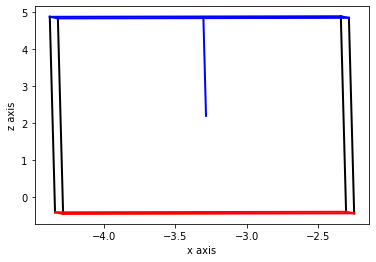

In [61]:
fig,ax=plt.subplots()
view_mtx=np.array([[1,0,0],[0,0,1],[0,1,0]])
bounding_box_in_camera_coord.render(ax,view=view_mtx)
plt.xlabel("x axis")
plt.ylabel("z axis")

In [62]:
bounding_box_in_camera_coord

label: nan, score: nan, xyz: [-3.31, 0.53, 2.22], wlh: [2.03, 5.30, 2.23], rot axis: [0.57, -0.58, 0.58], ang(degrees): 118.76, ang(rad): 2.07, vel: nan, nan, nan, name: car, token: None

In [63]:
bounding_box_in_camera_coord.corners().shape

(3, 8)

In [64]:
bounding_box_in_camera_coord.corners()

array([[-4.37672205, -2.34342277, -2.28698957, -4.32028885, -4.34006723,
        -2.30676796, -2.25033476, -4.28363404],
       [-0.50892956, -0.56014287,  1.6677267 ,  1.71894002, -0.6121768 ,
        -0.66339011,  1.56447947,  1.61569278],
       [ 4.87728923,  4.8923638 ,  4.84931213,  4.83423756, -0.41757738,
        -0.40250281, -0.44555448, -0.46062905]])

In [65]:
maxz=bounding_box_in_camera_coord.corners()[2,:].max()
minz=bounding_box_in_camera_coord.corners()[2,:].min()

In [66]:
dz=maxz-minz
np.arccos(5.49/dz)*180/np.pi

/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arccos
  


nan

It seems that the camera is slightly tilted.

Use bottom corners?

In [67]:
bounding_box_in_camera_coord.bottom_corners()

array([[-2.28698957, -4.32028885, -4.28363404, -2.25033476],
       [ 1.6677267 ,  1.71894002,  1.61569278,  1.56447947],
       [ 4.84931213,  4.83423756, -0.46062905, -0.44555448]])

## Convert to car ego coordinate

In [68]:
bounding_box_in_ego_coord=transform_box_from_world_to_ego_coordinates(bounding_box,camera_token)

In [69]:
bounding_box_in_ego_coord

label: nan, score: nan, xyz: [3.71, 3.30, 1.20], wlh: [2.03, 5.30, 2.23], rot axis: [-0.82, -0.23, 0.53], ang(degrees): 1.48, ang(rad): 0.03, vel: nan, nan, nan, name: car, token: None

Text(0, 0.5, 'y axis')

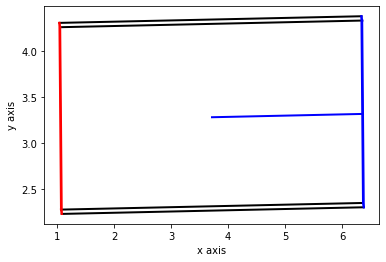

In [70]:
fig,ax=plt.subplots()
view_mtx=np.array([[1,0,0],[0,1,0],[0,0,1]])
bounding_box_in_ego_coord.render(ax,view=view_mtx)
plt.xlabel("x axis")
plt.ylabel("y axis")

The ego car is not exactly flat!

## Convert to flat vehicle coordinates

In [71]:
bounding_box_in_flat_vehicle_coord=transform_box_from_world_to_flat_vehicle_coordinates(bounding_box,camera_token)

Text(0, 0.5, 'y axis')

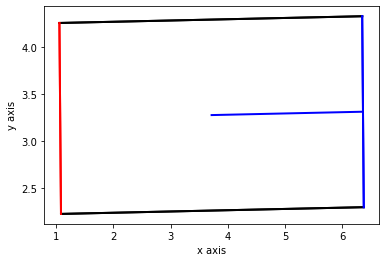

In [72]:
fig,ax=plt.subplots()
view_mtx=np.array([[1,0,0],[0,1,0],[0,0,1]])
bounding_box_in_flat_vehicle_coord.render(ax,view=view_mtx)
plt.xlabel("x axis")
plt.ylabel("y axis")

In [73]:
bounding_box_in_flat_vehicle_coord

label: nan, score: nan, xyz: [3.72, 3.28, 1.25], wlh: [2.03, 5.30, 2.23], rot axis: [0.00, 0.00, 1.00], ang(degrees): 0.78, ang(rad): 0.01, vel: nan, nan, nan, name: car, token: None

## Convert ego to flat sensor coordinates

Investigate the transformation

In [74]:
sample_data_token=camera_token
sd_record = level5data.get("sample_data", sample_data_token)
cs_record = level5data.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
sensor_record = level5data.get("sensor", cs_record["sensor_token"])
pose_record = level5data.get("ego_pose", sd_record["ego_pose_token"])

# Move box to ego vehicle coord system parallel to world z plane
ypr = Quaternion(cs_record["rotation"]).yaw_pitch_roll
yaw = ypr[0]

In [75]:
np.array(ypr)*180/np.pi

array([-75.06181379,  88.49741718, -14.69265635])

In [76]:
inv_ypr=Quaternion(cs_record["rotation"]).inverse.yaw_pitch_roll

In [77]:
np.array(inv_ypr)*180/np.pi

array([89.61270704, -0.24061729, 88.54654913])

This makes sense. Rotate z-axis by 90 degree, and then rotate x by 90 degree.

## Try the conversion from world to flat sensor coordinates

### Break down the conversion

In [78]:
sample_data_token=camera_token
sd_record = level5data.get("sample_data", sample_data_token)
cs_record = level5data.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
sensor_record = level5data.get("sensor", cs_record["sensor_token"])
pose_record = level5data.get("ego_pose", sd_record["ego_pose_token"])

# Move box to ego vehicle coord system parallel to world z plane
ypr = Quaternion(pose_record["rotation"]).yaw_pitch_roll
yaw = ypr[0]



#### world to vehicle

In [79]:
sample_box=bounding_box.copy()

sample_box.translate(-np.array(pose_record["translation"]))
#sample_box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
sample_box.rotate(Quaternion(pose_record['rotation']).inverse)
sample_box

label: nan, score: nan, xyz: [3.71, 3.30, 1.20], wlh: [2.03, 5.30, 2.23], rot axis: [-0.82, -0.23, 0.53], ang(degrees): 1.48, ang(rad): 0.03, vel: nan, nan, nan, name: car, token: None

In [80]:
#### flat vehicle to flat sensor

In [81]:
sample_box.translate(-np.array(cs_record["translation"]))
#sample_box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
sample_box.rotate(Quaternion(cs_record['rotation']).inverse)
sample_box

label: nan, score: nan, xyz: [-3.31, 0.53, 2.22], wlh: [2.03, 5.30, 2.23], rot axis: [0.57, -0.58, 0.58], ang(degrees): 118.76, ang(rad): 2.07, vel: nan, nan, nan, name: car, token: None

In [82]:
ypr=sample_box.orientation.yaw_pitch_roll
np.array(ypr)*180/np.pi

array([90.39668737, -1.45075342, 88.89294604])

May well just use ```ypr[0]``` as an approximation of heading angle

In [83]:
bounding_box_in_flat_sensor_coord=transform_box_from_world_to_flat_sensor_coordinates(bounding_box,camera_token)

Text(0, 0.5, 'z axis')

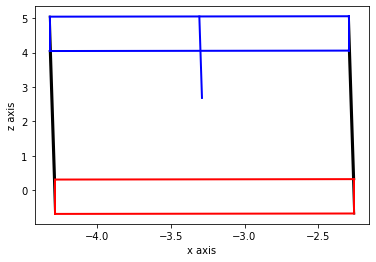

In [84]:
fig,ax=plt.subplots()
view_mtx=np.array([[1,0,0],[0,0,1],[0,1,0]])
bounding_box_in_flat_sensor_coord.render(ax,view=view_mtx)
plt.xlabel("x axis")
plt.ylabel("z axis")

In [85]:
bounding_box_in_flat_sensor_coord.corners()

array([[-4.32428767, -2.29033428, -2.29033428, -4.32428767, -4.28843135,
        -2.25447797, -2.25447797, -4.28843135],
       [-2.81419489, -2.82036535, -0.82764679, -0.82147633, -0.44125141,
        -0.44742187,  1.54529669,  1.55146716],
       [ 4.04502153,  4.05733284,  5.05608893,  5.04377762, -0.68947629,
        -0.67716497,  0.32159112,  0.3092798 ]])

In [86]:
bounding_box_in_flat_sensor_coord.orientation.degrees

136.54420226045318

In [87]:
ypr=bounding_box_in_flat_sensor_coord.orientation.yaw_pitch_roll

In [88]:
np.array(ypr)*180/np.pi

array([ 90.38792125,   0.        , 116.62015618])

In [89]:
first_train_sample['data']

{'CAM_FRONT': 'bf374e60b6a1b0b9d4c0e3cf9e92b1f5d8401eae774ec1ebb3aa2f6bee59d1e5',
 'CAM_BACK_LEFT': '521ca50fff810fcb6f70170f6a6b48709e55164902e34df1e8e3d95b5b56572e',
 'CAM_FRONT_RIGHT': 'e35731e7cc91018cbafd323f635d97ccbd948642c19937b85521bd2f9918efcc',
 'CAM_BACK': '762f245c3f3a0cfe3a9bc97eb321eb71522eaff0904469693b9c712041fcf0a1',
 'CAM_BACK_RIGHT': '89ef38638f8f4cbd932f693e934c4022681de809417a50679c9b20914286efb5',
 'LIDAR_FRONT_RIGHT': '0d3a497e9c99f8a4697e0e9d2644a8a7e3bd20143b58dba8285b63dd1715b794',
 'CAM_FRONT_LEFT': 'a8b62cfacbdb74d34051f2ace4e3e89c8eb19bab1c8830ab16a5b671a3bc9971',
 'LIDAR_TOP': 'f2f0d25a268a7a7112be881669bf0b4848ae591c8c70de1a8e562b81c45654d4',
 'LIDAR_FRONT_LEFT': 'cc0c6d32e941040f2e4a384ab9707516ca39d36b9f66baa4ab24b31cdb882bf7',
 'CAM_FRONT_ZOOMED': '2968bff405ae8834b9d2e12ce2a004a70a6b1d99b6e93351af5c5826026d4ea1'}

In [90]:
lidar_token=first_train_sample['data']['LIDAR_TOP']
demo_lidar_file_path=level5data.get_sample_data_path(lidar_token)

In [91]:
lcp=LidarPointCloud.from_file(demo_lidar_file_path)

(-50, 50)

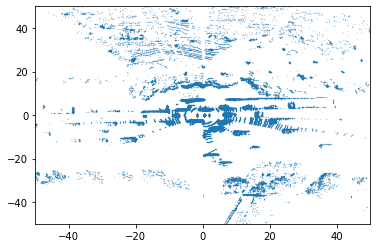

In [35]:
plt.plot(lcp.points[0,:],lcp.points[1,:],'.',markersize=0.2)
plt.xlim([-50,50])
plt.ylim([-50,50])

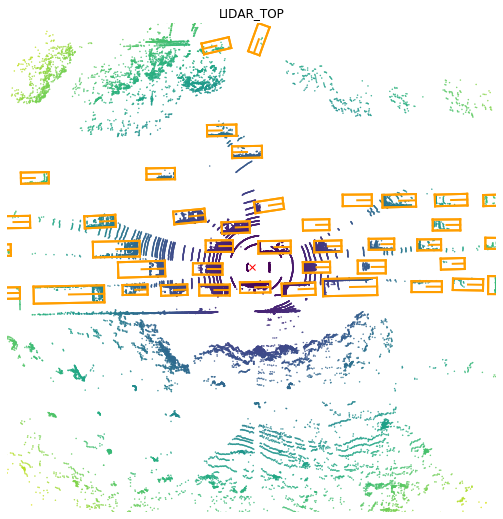

In [36]:
level5data.render_sample_data(lidar_token)

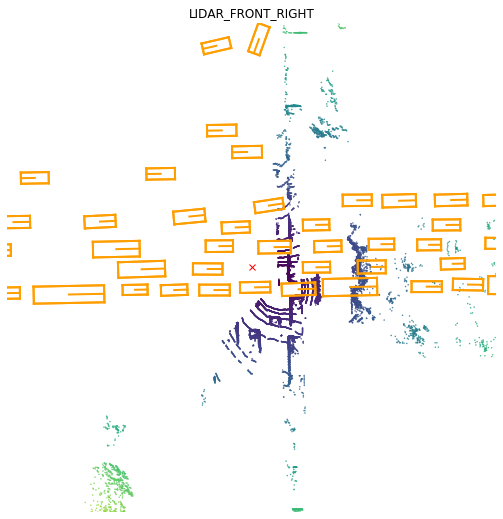

In [37]:
lidar_token=first_train_sample['data']['LIDAR_FRONT_RIGHT']
level5data.render_sample_data(lidar_token)

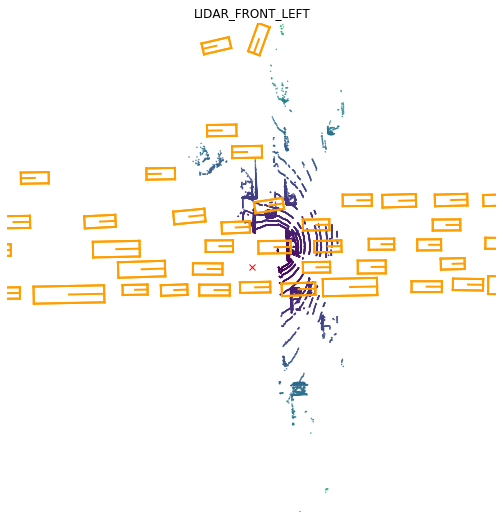

In [38]:
lidar_token=first_train_sample['data']['LIDAR_FRONT_LEFT']
level5data.render_sample_data(lidar_token)

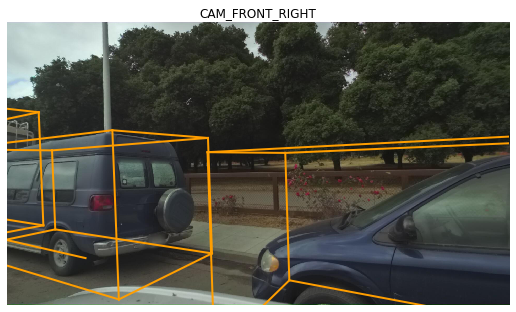

In [39]:
lidar_token=first_train_sample['data']['CAM_FRONT_RIGHT']
level5data.render_sample_data(lidar_token)

In [40]:
cam_token = first_train_sample['data']['CAM_FRONT']

box_corners = get_bounding_box_corners(bounding_box, cam_token)

# check)image
cam_image_file = level5data.get_sample_data_path(cam_token)
cam_image_mtx = imread(cam_image_file)

xmin, xmax, ymin, ymax = get_2d_corners_from_projected_box_coordinates(box_corners)

random_depth = 20
image_center = np.array([[(xmax + xmin) / 2, (ymax + ymin) / 2, random_depth]]).T

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
lidar_token=first_train_sample['data']['LIDAR_TOP']
level5data.get_sample_data(lidar_token)

In [ ]:
image_wc = transform_image_to_world_coordinate(image_center, cam_token)

In [ ]:
image_wc

### confirm that the projection is correct

In [ ]:
transform_world_to_image_coordinate(image_wc,cam_token)

In [ ]:
image_center

## Dissect the steps

In [ ]:
def normalization(input_array):
    input_array[0:2,:]=input_array[0:2,:]*input_array[2:3,:].repeat(2,0).reshape(2,input_array.shape[1])
    return input_array

In [ ]:
image_array=np.copy(image_center)
camera_token=cam_token

In [ ]:
image_array=normalization(image_array)
image_array=np.concatenate((image_array.ravel(),np.array([1])))
image_array=image_array.reshape(4,1)

In [ ]:
image_array

In [ ]:
sd_record = level5data.get("sample_data", camera_token)
cs_record = level5data.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
sensor_record = level5data.get("sensor", cs_record["sensor_token"])
pose_record = level5data.get("ego_pose", sd_record["ego_pose_token"])

# inverse the viewpoint transformation


cam_intrinsic_mtx = np.array(cs_record["camera_intrinsic"])
view=cam_intrinsic_mtx
viewpad=np.eye(4)
viewpad[: view.shape[0], : view.shape[1]] = view
image_in_cam_coord = np.dot(np.linalg.inv(viewpad), image_array)

print("image_in_cam_coord",image_in_cam_coord)
# TODO: think of how to do normalization properly
# image_in_cam_coord = image_in_cam_coord / image_in_cam_coord[3:].ravel()

# homogeneous coordinate to non-homogeneous one
image_in_cam_coord = image_in_cam_coord[0:3, :]

sens_to_pose_rot_mtx = Quaternion(cs_record['rotation']).rotation_matrix

image_in_pose_coord = np.dot(sens_to_pose_rot_mtx, image_in_cam_coord)
t = np.array(cs_record['translation'])
for i in range(3):
    image_in_pose_coord[i, :] = image_in_cam_coord[i, :] + t[i]
    

print("in pose record:", image_in_pose_coord)

pose_to_world_rot_mtx = Quaternion(pose_record['rotation']).rotation_matrix

image_in_world_coord = np.dot(pose_to_world_rot_mtx,
                              image_in_pose_coord)
t = np.array(pose_record['translation'])
for i in range(3):
    image_in_world_coord[i, :] = image_in_world_coord[i, :] + t[i]

In [ ]:
image_in_world_coord

In [ ]:
transform_world_to_image_coordinate(image_in_world_coord,cam_token)

In [ ]:
image_in_cam_coord[2:3,:].repeat(3,0).reshape(3,image_array.shape[1])

In [ ]:
def project_image_to_rect(uv_depth):
    ''' Input: nx3 first two channels are uv, 3rd channel
               is depth in rect camera coord.
        Output: nx3 points in rect camera coord.
    '''
    
    n = uv_depth.shape[0]
    x = ((uv_depth[:,0]-c_u)*uv_depth[:,2])/f_u + b_x
    y = ((uv_depth[:,1]-c_v)*uv_depth[:,2])/f_v + b_y
    pts_3d_rect = np.zeros((n,3))
    pts_3d_rect[:,0] = x
    pts_3d_rect[:,1] = y
    pts_3d_rect[:,2] = uv_depth[:,2]
    return pts_3d_rect

## Only to camera coordinates

In [ ]:
cam_intrinsic_mtx = np.array(cs_record["camera_intrinsic"])
view=cam_intrinsic_mtx
viewpad=np.eye(4)
viewpad[: view.shape[0], : view.shape[1]] = view
image_in_cam_coord = np.dot(np.linalg.inv(viewpad), image_array)

print("image_in_cam_coord",image_in_cam_coord)

In [ ]:
from lyft_dataset_sdk.utils.geometry_utils import view_points

In [ ]:
view_points(image_in_cam_coord[0:3,:],view=cam_intrinsic_mtx,normalize=True)